In [1]:
import os, glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import csv
import seaborn as sns
from sklearn.model_selection import train_test_split

**Loading data and creating one fine from test and train data**

In [2]:
os.chdir("C:/Users/admin/Desktop/Workings/data_science/projects/sign_language/")


extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

#combine all files in the list
DataSet_merged = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
DataSet_merged.to_csv( "DataSet_merged.csv", index=False, encoding='utf-8-sig')


dataset_test = pd.read_csv('C:/Users\admin\Desktop\Workings\data_science\projects\sign_language\sign_mnist_test.csv')
dataset_train = pd.read_csv('C:/Users\admin\Desktop\Workings\data_science\projects\sign_language\sign_mnist_train.csv')
dataset_merged = pd.read_csv('C:/Users\admin\Desktop\Workings\data_science\projects\sign_language\DataSet_merged.csv')

print(len(dataset_merged))
print(len(dataset_test))
print(len(dataset_train))


34627
7172
27455


In [3]:
def get_data(filename):
    with open(filename) as training_file:
        reader = csv.reader(training_file, delimiter=',')    
        imgs = []
        labels = []

        next(reader, None)
        
        for row in reader:
            label = row[0]
            data = row[1:]
            img = np.array(data).reshape((28, 28))

            imgs.append(img)
            labels.append(label)

        images = np.array(imgs).astype(float)
        labels = np.array(labels).astype(float)
        
    return images, labels

In [4]:
path_sign_data = f"C:/Users\admin\Desktop\Workings\data_science\projects\sign_language\DataSet_merged.csv"
images, labels = get_data(path_sign_data)

print(images.shape)
print(labels.shape)

(34627, 28, 28)
(34627,)


**Show labels**

C:\Users\potapenk\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

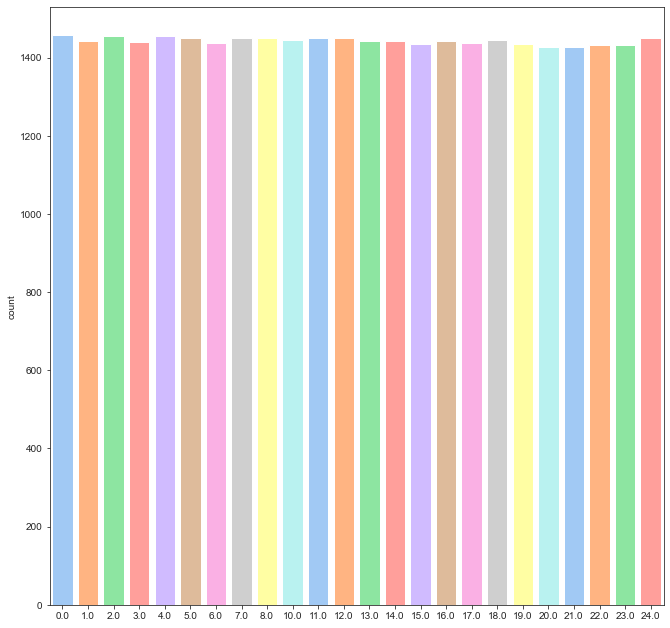

In [9]:
plt.figure(figsize = (11,11))
sns.set_style("ticks")
sns.countplot(labels, palette="pastel", saturation=1)

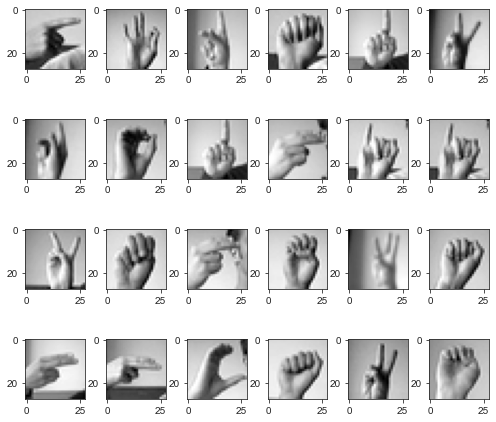

In [10]:
v, h = plt.subplots(4,6) 
v.set_size_inches(7, 7)
k = 0
for i in range(4):
    for j in range(6):
        h[i,j].imshow(images[k], cmap = "gray")
        k += 1
    plt.tight_layout(w_pad=0.2, h_pad=0.2)   

In [11]:
from sklearn.preprocessing import LabelBinarizer
LB = LabelBinarizer()
labels = LB.fit_transform(labels)
labels.shape

(34627, 24)

**Train / Test split**

In [12]:
train_images, test_images, train_labels, test_labels = train_test_split( images, labels, test_size=0.25, random_state=4)
print ('Train set:', train_images.shape,  train_labels.shape)
print ('Test set:', test_images.shape,  test_labels.shape)

Train set: (25970, 28, 28) (25970, 24)
Test set: (8657, 28, 28) (8657, 24)


**Padding and creating an ImageDataGenerator and doing Image Augmentation**

In [13]:
train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)

max_value = np.ndarray.max(images).astype(float)

train_datagen = ImageDataGenerator(rescale = 1./max_value,
#                                    rotation_range = 40,
#                                    width_shift_range = 0.2,
#                                    height_shift_range = 0.2,
#                                    shear_range = 0.2,
#                                    zoom_range = 0.2,
#                                    horizontal_flip = True
                                  )

validation_datagen = ImageDataGenerator(rescale = 1.0/max_value)


train_generator = train_datagen.flow(
    train_images,
    train_labels,
    #target_size=(28,28),
    #class_mode='categorical',
    #batch_size=24
    )

validation_generator = validation_datagen.flow(
    test_images,
    test_labels,
    #target_size=(28,28),
    #class_mode='categorical',
    #batch_size=24
    #steps_per_epoch = len(training_images)/32, 
    #epoch=2
    )
    
print(train_images.shape)
print(test_images.shape)

(25970, 28, 28, 1)
(8657, 28, 28, 1)


**Creating class callbacks**

In [14]:
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if(logs.get('accuracy')>0.970):
                print("\nReached 97.0% accuracy so cancelling training!")
                self.model.stop_training = True
    
callbacks = myCallback()

**Contructing a model**

In [15]:
model = tf.keras.models.Sequential([
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(24, activation='softmax')
])


model.summary()

model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
history = model.fit(train_generator, epochs=30, steps_per_epoch=100, validation_data = validation_generator, verbose = 1, validation_steps=3, callbacks=[callbacks])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               8

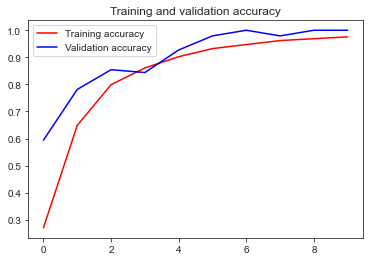

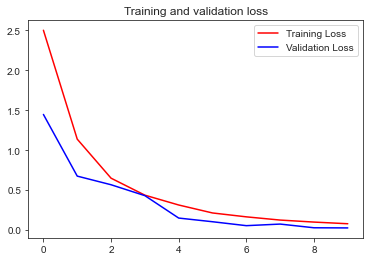

In [16]:
# Plot the chart for accuracy and loss on both training and validation

acc = history.history['accuracy']# Your Code Here
val_acc = history.history['val_accuracy']# Your Code Here
loss = history.history['loss']# Your Code Here
val_loss = history.history['val_loss']# Your Code Here

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()